# Opće uvjetovanosti

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def skini(url: str, datoteka: str):
    import urllib.request as rq, pathlib
    with rq.urlopen(url) as konekcija:
        pathlib.Path(datoteka).write_bytes(konekcija.read())
        
test_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/test.csv'
train_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/train.csv'
skini(test_podaci, 'test_podaci.csv')
skini(train_podaci, 'train_podaci.csv')

In [5]:
test_data = pd.read_csv('test_podaci.csv')
train_data = pd.read_csv('train_podaci.csv')

In [6]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# k-nn 

In [7]:
import nltk
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.corpus import genesis
from nltk.corpus import stopwords
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
genesis_ic = wn.ic(genesis, False, 0.0)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import csv

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sada kada imamo podatke, počistit ćemo neke od čestih riječi (eng. stopwords), kako bismo imali kvalitetnije značajke. Osim toga sve pretvaramo u mala slova.

In [8]:
df_train = train_data
df_test = test_data

s = stopwords.words('english')
# dodatne stop riječi
s.extend(['today', 'tomorrow', 'outside', 'out', 'there'])
ps = nltk.wordnet.WordNetLemmatizer()

for i in range(df_train.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df_train.loc[i,'text'])
    review = review.lower()
    review = review.split()
    review = [ps.lemmatize(word) for word in review if not word in s]
    review = ' '.join(review)
    df_train.loc[i, 'text'] = review
    
X_train = df_train['text']
y_train = df_train['target']

print("df_train nakon micanja stop riječi")
print(df_train['text'][:10])

for i in range(df_test.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df_test.loc[i,'text'])
    review = review.lower()
    review = review.split()
    review = [ps.lemmatize(word) for word in review if not word in s]
    review = ' '.join(review)
    df_test.loc[i, 'text'] = review
    
X_test = df_test['text']

print("df_test nakon micanja stop riječi")
print(df_test['text'][:10])

df_train nakon micanja stop riječi
0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain cause flash flooding...
7                               top hill see fire wood
8    emergency evacuation happening building across...
9                           afraid tornado coming area
Name: text, dtype: object
df_test nakon micanja stop riječi
0                          happened terrible car crash
1    heard earthquake different city stay safe ever...
2    forest fire spot pond goose fleeing across str...
3                 apocalypse lighting spokane wildfire
4                   typhoon soudelor kill china taiwan
5                                   shaking earthquake
6     probably still show

Prvi model nam je k-nn. Tweetove pretvaramo u matrice koristeći se metodom *CountVectorizer* koja pamti frekvencije pojavljivanja riječi iz određene abecede (u ovom slučaju svih riječi koje se pojavljuju). Matricu zatim normaliziramo metodom *tfidf_transformer* i možemo lagano predvidjeti oznake pomoću k-nn

In [9]:
# izgradi rječnik značajki i pretvori tweetove u matricu s frekvencijama tokena 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# pretvori matricu u  normalnu tf-idf reprezentaciju
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

<7613x20677 sparse matrix of type '<class 'numpy.float64'>'
	with 81987 stored elements in Compressed Sparse Row format>

In [10]:
knn = KNeighborsClassifier(n_neighbors = 1)

clf = knn.fit(X_train_tfidf, y_train)

primjer = [X_test[0]]
X_ex_counts = count_vect.transform(primjer)
# koristimo se transform metodom, jer je model već fitan
X_ex_tfidf = tfidf_transformer.transform(X_ex_counts)
predicted = clf.predict(X_ex_tfidf)
predicted

array([0], dtype=int64)

In [11]:
def knn_pipeline(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [13]:
from sklearn.model_selection import train_test_split
X_train_findk, X_test_findk, y_train_findk, y_test_findk = train_test_split(X_train, y_train, test_size = 0.2, random_state = 4)

In [14]:
predicted = knn_pipeline(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

0.6018068102849201

In [15]:
# export u csv
def export_csv(predicted, file_name):
    """Args: list of predicted values, string containing the file name to export to"""
    
    dict = {"id":list(df_test["id"]), "target":predicted}
    df_test_export = pd.DataFrame(dict)
    df_test_export.set_index("id", inplace = True)
    retci = [["id", "target"]]
    for i in range(len(df_test_export.index)):
        retci.append([df_test_export.index[i], predicted[i]])
    
    np.savetxt(file_name, retci, delimiter =",", fmt ='% s')

Iskoristimo trening set kako bismo pronašli što bolji *k*. 

In [18]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles safety fastener ...
3259,10865,NaN,NaN,storm ri worse last hurricane city amp others ...
3260,10868,NaN,NaN,green line derailment chicago http co utbxlcbiuy
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo http c...


Minimum error:- 0.22390019697964544 at K = 40
CPU times: total: 0 ns
Wall time: 0 ns


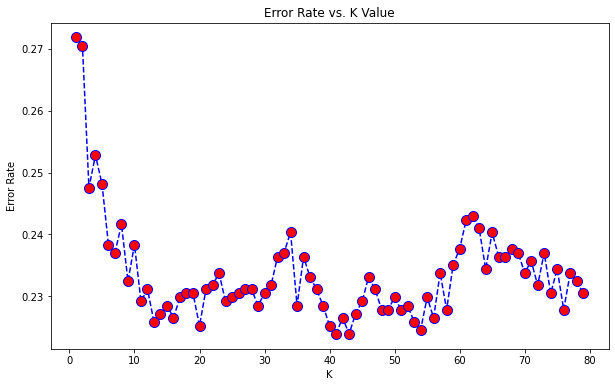

In [16]:
error_rate = []
for i in range(1, 80):
    predicted = knn_pipeline(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
    error_rate.append(np.mean(predicted != y_test_findk))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 80), error_rate, color = 'blue', linestyle = 'dashed', 
         marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate), "at K =", error_rate.index(min(error_rate)))
%time

Maximum f1 score:- 0.7151211361737678 at K = 43


UsageError: Line magic function `%%time` not found.


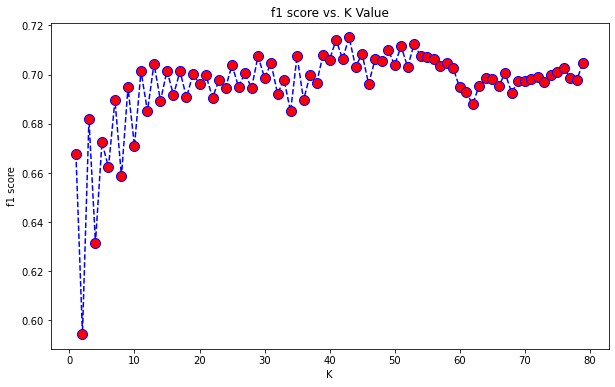

In [17]:
%%time
f1 = []
# (best_f1_score, k_value)
best_score = (0, 0)
    
for i in range(1, 80):
    predicted = knn_pipeline(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 

    f1.append(f1_score(y_test_findk, predicted))

    if f1[i - 1] > best_score[0]:
        best_score = (f1[i - 1], i)
        best_prediction = predicted

plt.figure(figsize = (10, 6))
plt.plot(range(1, 80), f1, color = 'blue', linestyle = 'dashed', 
             marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
print("Maximum f1 score:-", best_score[0], "at K =", best_score[1])

In [ ]:
#export_csv(knn_pipeline(42), "best_k.csv")

In [19]:
best_prediction.uni

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

Pogledajmo ima li smisla smanjiti vokabular samo na ključne riječi koje smo dobili u podacima

In [ ]:
keywords = list(train_data["keyword"].unique())
keywords.remove(keywords[0]) # makni nan
keywords

In [ ]:
f1 = []
# (best_f1_score, k_value)
best_score = (0, 0)

for i in range(1, 80):
    predicted = knn_pipeline(i, vocabulary = keywords, train_x = X_train_findk, train_y = y_train_findk,
                             predict_x = X_test_findk) 
    
    f1.append(f1_score(y_test_findk, predicted))
    
    if f1[i - 1] > best_score[0]:
        best_score = (f1[i - 1], i)
        best_prediction = predicted

plt.figure(figsize = (10, 6))
plt.plot(range(1, 80), f1, color = 'blue', linestyle = 'dashed', 
         marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
print("Maximum f1 score:-", best_score[0], "at K =", best_score[1])
%time

Očito model nije dovoljno kompleksan smanjivanjem vokabulara samo na ove ključne riječi. Možemo li krenuti suprotnim smjerom smanjenjem dimenzionalnosti ili odabirom značajki?

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=500,
                 cv=StratifiedKFold(n_splits=2),
                 scoring='f1')

In [ ]:
def knn_pipeline_features(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('feat', rfecv_rf),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [ ]:
predicted = knn_pipeline_features(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

Vidimo da nemamo sreće s odabirom značajki, a i postupak je predug da bismo otkrili najbolji mogući broj.

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
def knn_pipeline_dim(k_value, vocabulary = None, train_x = X_train, train_y = y_train, predict_x = X_test):
    # sve zajedno stavljamo u pipeline
    knn = KNeighborsClassifier(n_neighbors = k_value)
    tweet_clf = Pipeline([
        ('vect', CountVectorizer(vocabulary = vocabulary)),
        ('tfidf', TfidfTransformer()),
        ('dim', TruncatedSVD()),
        ('clf', knn),
    ])
    # fitamo podatke za treniranje
    tweet_clf.fit(train_x, train_y)
    
    # klasificiramo testne podatke
    predicted = tweet_clf.predict(predict_x)
    
    return predicted

In [ ]:
predicted = knn_pipeline_dim(i, train_x = X_train_findk, train_y = y_train_findk, predict_x = X_test_findk) 
f1_score(y_test_findk, predicted)

Isto kao niti sa smanjenjem dimenzionalnosti. Koristimo se metodom TruncatedSVD koja je preporučena metoda za rad sa rijetkim matricama

Možemo li modificirati mjeru unutar k-nna da određenim riječima daje veću težinu?

# Transformeri